In [ ]:
!pip install tf-playwright-stealth

In [ ]:
# EUvsDISINFO Scraper
# Import necessary libraries
import pandas as pd
import asyncio
import nest_asyncio
from playwright.async_api import async_playwright
from playwright_stealth import stealth_async        # Import stealth_async for stealth mode in order to avoid detection

nest_asyncio.apply()  # Apply nest_asyncio to allow nested event loops

async def scrape_eu_vs_disinfo():
    pw = None
    browser = None
    results = []  # Initialize an empty list to store results
    try:
        pw = await async_playwright().start()  # Start Playwright
        browser = await pw.chromium.launch(headless=False)  # Launch Chromium browser in non-headless mode because the website detects headless browsers
        page = await browser.new_page()  # Create a new page in the browser


        await stealth_async(page)  # Apply stealth mode to avoid detection
        url = f"https://euvsdisinfo.eu/disinformation-cases/page/1/?disinfo_countries%5B0%5D=country_77544&_=1750026467335"
        await page.goto(url, timeout=120000, wait_until='domcontentloaded')  # Navigate to the page
        await asyncio.sleep(1)  # Small delay for ethical scraping

        pagination_tags = await page.query_selector('div.b-pagination a:last-child')  # Select last pagination item
        num_pages = await pagination_tags.inner_text()  # Get the number of pages
        print(f"Number of pages: {num_pages}")
        num_pages = int(num_pages)

        for page_num in range(1, num_pages + 1):  # Iterating through web pages
            if page_num > 1:

                await stealth_async(page)  # Apply stealth mode to avoid detection
                print(f"Navigating to page {page_num}...")
                url = f"https://euvsdisinfo.eu/disinformation-cases/page/{page_num}/?disinfo_countries%5B0%5D=country_77544&_=1750026467335"
                await page.goto(url, timeout=120000, wait_until='domcontentloaded')  # Navigate to the page
                print(f"Page {page_num} loaded.")
                await asyncio.sleep(1)  # Small delay for ethical scraping

            article_cards = await page.query_selector_all('a.b-archive__database-item') # Select all article cards on the page

            # Extract data from the first few cards
            for i, card in enumerate(article_cards):
                outlet = []  # Initialize an empty list for outlets
                tags = []  # Initialize an empty list for tags
                title = "N/A"  # Initialize title as "N/A"
                summary = "N/A"  # Initialize summary as "N/A"
                response = "N/A"  # Initialize response as "N/A"
                date = "N/A"  # Initialize date as "N/A"
                languages = []  # Initialize an empty list for languages
                countries = []  # Initialize an empty list for countries

                url = await card.get_attribute('href') # Get the URL of the article

                article_page = await browser.new_page()  # Create a new page for article


                await stealth_async(article_page)  # Apply stealth mode to avoid detection
                await article_page.goto(f"https://euvsdisinfo.eu{url}", timeout=120000, wait_until='domcontentloaded')  # Navigate to the article page
                await asyncio.sleep(1) # Small delay for ethical scraping

                try:
                    await article_page.wait_for_selector('h1.b-page__title', timeout=100)  # Wait for the title to load
                except Exception as e:
                    title_tag = await article_page.query_selector('h1.b-report__title')  # Select the title of the article
                    title = await title_tag.inner_text() if title_tag else "N/A"  # Get the title text
                    title = title.replace("DISINFO: ", "")  # Clean the title text

                    summary_tag = await article_page.query_selector('div.b-report__summary')  # Select the summary of the article
                    summary = await summary_tag.inner_text() if summary_tag else "N/A"  # Get the summary text
                    summary = summary.replace("SUMMARY\n\n", "")  # Clean the summary text

                    response_tag = await article_page.query_selector('div.b-report__response')  # Select the response of the article
                    response = await response_tag.inner_text() if response_tag else "N/A"  # Get the response text
                    response = response.replace("RESPONSE\n\n", "")  # Clean the response text

                    details = await article_page.query_selector_all('ul.b-report__details-list li')  # Select the details of the article

                    if len(details) == 2:
                        date_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(1) span')  # Select the date of the article
                        date = await date_tag.inner_text() if date_tag else "N/A"  # Get the date text

                        countries_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(2) span')  # Select the countries of the article
                        countries = [await countries_tag.inner_text()]  # Get the countries text
                        countries = countries[0].split(", ") if countries else []  # Split the countries text into a list
                    elif len(details) >= 3:
                        outlet_tag = await article_page.query_selector_all('ul.b-report__details-list li:nth-child(1) a')  # Select the outlets of the article
                        for j, outlet_item in enumerate(outlet_tag):  # Iterate through each outlet
                            outlet_text = await outlet_item.inner_text()  # Get the outlet text
                            if outlet_text and not outlet_text.strip().__contains__("archived"):  # Clean the outlet text and append it to the outlet list
                                outlet.append(outlet_text.strip().replace("\\n(opens in a new tab)", "").replace("\n(opens in a new tab)", ""))

                        date_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(2) span')  # Select the date of the article
                        date = await date_tag.inner_text() if date_tag else "N/A"  # Get the date text

                        if len(details) == 4:
                            languages_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(3) span')  # Select the languages of the article
                            languages = [await languages_tag.inner_text()]  # Get the languages text
                            languages = languages[0].split(", ") if languages else []  # Split the languages text into a list
                            languages = list(set(languages))  # Remove duplicates

                            countries_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(4) span')  # Select the countries of the article
                            countries = [await countries_tag.inner_text()]  # Get the countries text
                            countries = countries[0].split(", ") if countries else []  # Split the countries text into a list
                        elif len(details) == 3:
                            languages = []

                            countries_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(3) span')  # Select the countries of the article
                            countries = [await countries_tag.inner_text()]  # Get the countries text
                            countries = countries[0].split(", ") if countries else []  # Split the countries text into a list

                    tags_tag = await article_page.query_selector_all('div.b-report__keywords a span')  # Select the tags of the article
                    for tag_item in tags_tag:  # Iterate through each tag
                        tag_text = await tag_item.inner_text()  # Get the tag text
                        if tag_text:
                            tags.append(tag_text.strip())  # Append the tag text to the tags list

                    results.append({  # Append the extracted data to the results list
                        'Title': title,
                        'URL': f"https://euvsdisinfo.eu{url}",
                        'Summary': summary,
                        'Response': response,
                        'Outlet': outlet,
                        'Date': date,
                        'Languages': languages,
                        'Countries': countries,
                        'Tags': tags
                    })
                await article_page.close()  # Close the article page after extracting data

        await browser.close()  # Close the browser after scraping
    except Exception as e:
        print(f"An error occurred during EUvsDISINFO search: {e}")
        # Optional: Take a screenshot on error for debugging
        # if page: await page.screenshot(path='error_screenshot.png')

    finally:
        if browser:  # Ensure the browser is closed
            await browser.close()
            print("Browser closed.")
        if pw:
            await pw.stop()  # Stop Playwright
            print("Playwright stopped.")

    return results  # Return the results list containing the scraped data

df = asyncio.run(scrape_eu_vs_disinfo())  # Run the scraping function
if df:
    df = pd.DataFrame(df)  # Convert the results list to a DataFrame
    print(f"Scraped {len(df)} results from EUvsDISINFO.")  # Display the number of results scraped
    df.to_csv('euvsdisinfo.csv', index=False)  # Save the DataFrame to a CSV file
else:
    print("\nNo results scraped from EUvsDISINFO.")  # Display a message if no results were scraped


# Export pages separately

In [ ]:
# EUvsDISINFO Scraper
# Import necessary libraries
import pandas as pd
import asyncio
import nest_asyncio
from playwright.async_api import async_playwright
from playwright_stealth import stealth_async        # Import stealth_async for stealth mode in order to avoid detection

nest_asyncio.apply()  # Apply nest_asyncio to allow nested event loops

async def scrape_eu_vs_disinfo(page_num=1):
    pw = None
    browser = None
    results = []  # Initialize an empty list to store results
    try:
        pw = await async_playwright().start()  # Start Playwright
        browser = await pw.chromium.launch(headless=False)  # Launch Chromium browser in non-headless mode because the website detects headless browsers
        page = await browser.new_page()  # Create a new page in the browser


        await stealth_async(page)  # Apply stealth mode to avoid detection
        print(f"Navigating to page {page_num}...")
        url = f"https://euvsdisinfo.eu/disinformation-cases/page/{page_num}/?disinfo_countries%5B0%5D=country_77544&_=1750022717762"
        await page.goto(url, timeout=120000, wait_until='domcontentloaded')  # Navigate to the page
        print(f"Page {page_num} loaded.")
        await asyncio.sleep(1) # Small delay for ethical scraping

        article_cards = await page.query_selector_all('a.b-archive__database-item') # Select all article cards on the page
        # Extract data from the first few cards
        for i, card in enumerate(article_cards):
            outlet = []  # Initialize an empty list for outlets
            tags = []  # Initialize an empty list for tags
            title = "N/A"  # Initialize title variable
            summary = "N/A"  # Initialize summary variable
            response = "N/A"  # Initialize response variable
            date = "N/A"  # Initialize date variable
            languages = []  # Initialize an empty list for languages
            countries = []  # Initialize an empty list for countries

            url = await card.get_attribute('href') # Get the URL of the article

            article_page = await browser.new_page()  # Create a new page for article


            await stealth_async(article_page)  # Apply stealth mode to avoid detection
            await article_page.goto(f"https://euvsdisinfo.eu{url}", timeout=120000, wait_until='domcontentloaded')  # Navigate to the article page
            await asyncio.sleep(1) # Small delay for ethical scraping

            try:
                await article_page.wait_for_selector('h1.b-page__title', timeout=50)  # Wait for the title to load
            except Exception as e:
                title_tag = await article_page.query_selector('h1.b-report__title')  # Select the title of the article
                title = await title_tag.inner_text() if title_tag else "N/A"  # Get the title text
                title = title.replace("DISINFO: ", "")  # Clean the title text

                summary_tag = await article_page.query_selector('div.b-report__summary')  # Select the summary of the article
                summary = await summary_tag.inner_text() if summary_tag else "N/A"  # Get the summary text
                summary = summary.replace("SUMMARY\n\n", "")  # Clean the summary text

                response_tag = await article_page.query_selector('div.b-report__response')  # Select the response of the article
                response = await response_tag.inner_text() if response_tag else "N/A"  # Get the response text
                response = response.replace("RESPONSE\n\n", "")  # Clean the response text

                details = await article_page.query_selector_all('ul.b-report__details-list li')  # Select the details of the article

                if len(details) == 2:
                    date_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(1) span')  # Select the date of the article
                    date = await date_tag.inner_text() if date_tag else "N/A"  # Get the date text

                    countries_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(2) span')  # Select the countries of the article
                    countries = [await countries_tag.inner_text()]  # Get the countries text
                    countries = countries[0].split(", ") if countries else []  # Split the countries text into a list
                elif len(details) >= 3:
                    outlet_tag = await article_page.query_selector_all('ul.b-report__details-list li:nth-child(1) a')  # Select the outlets of the article
                    for j, outlet_item in enumerate(outlet_tag):  # Iterate through each outlet
                        outlet_text = await outlet_item.inner_text()  # Get the outlet text
                        if outlet_text and not outlet_text.strip().__contains__("archived"):  # Clean the outlet text and append it to the outlet list
                            outlet.append(outlet_text.strip().replace("\\n(opens in a new tab)", "").replace("\n(opens in a new tab)", ""))

                    date_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(2) span')  # Select the date of the article
                    date = await date_tag.inner_text() if date_tag else "N/A"  # Get the date text

                    if len(details) == 4:
                        languages_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(3) span')  # Select the languages of the article
                        languages = [await languages_tag.inner_text()]  # Get the languages text
                        languages = languages[0].split(", ") if languages else []  # Split the languages text into a list
                        languages = list(set(languages))  # Remove duplicates

                        countries_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(4) span')  # Select the countries of the article
                        countries = [await countries_tag.inner_text()]  # Get the countries text
                        countries = countries[0].split(", ") if countries else []  # Split the countries text into a list
                    elif len(details) == 3:
                        languages = []

                        countries_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(3) span')  # Select the countries of the article
                        countries = [await countries_tag.inner_text()]  # Get the countries text
                        countries = countries[0].split(", ") if countries else []  # Split the countries text into a list

                tags_tag = await article_page.query_selector_all('div.b-report__keywords a span')  # Select the tags of the article
                for tag_item in tags_tag:  # Iterate through each tag
                    tag_text = await tag_item.inner_text()  # Get the tag text
                    if tag_text:
                        tags.append(tag_text.strip())  # Append the tag text to the tags list

                results.append({  # Append the extracted data to the results list
                    'Title': title,
                    'URL': f"https://euvsdisinfo.eu{url}",
                    'Summary': summary,
                    'Response': response,
                    'Outlet': outlet,
                    'Date': date,
                    'Languages': languages,
                    'Countries': countries,
                    'Tags': tags
                })
            await article_page.close()  # Close the article page after extracting data

        await browser.close()  # Close the browser after scraping
    except Exception as e:
        print(f"An error occurred during EUvsDISINFO search: {e}")
        # Optional: Take a screenshot on error for debugging
        # if page: await page.screenshot(path='error_screenshot.png')

    finally:
        if browser:  # Ensure the browser is closed
            await browser.close()
            print("Browser closed.")
        if pw:
            await pw.stop()  # Stop Playwright
            print("Playwright stopped.")

    return results  # Return the results list containing the scraped data

pages = [5, 6, 7, 10, 11, 17, 24, 25, 27, 57, 60, 65, 70, 78, 97, 211, 488]  # Pages which we had to rescrape

for i in pages:
    df = asyncio.run(scrape_eu_vs_disinfo(i))  # Run the scraping function for each page
    if df:
        df = pd.DataFrame(df)  # Convert the results list to a DataFrame
        df.to_csv(f'euvsdisinfo_results_page_{i}.csv', index=False)  # Save the DataFrame to a CSV file
    else:
        print(f"\nNo results scraped from EUvsDISINFO for page {i}.")  # Display a message if no results were scraped


In [ ]:
import pandas as pd

df = pd.DataFrame([])  # Initialize an empty DataFrame to store all pages
for i in range(1, 515):
    pg = pd.read_csv(f'euvsdisinfo_results_page_{i}.csv')  # Read the CSV file for each page
    df = pd.concat([df, pg], ignore_index=True)  # Append the DataFrame for each page to the list

df.to_csv('euvsdisinfo_results.csv', index=False)  # Save the combined DataFrame to a CSV file

In [39]:
!pip install textblob
import pandas as pd
from textblob import TextBlob

# Load the CSV
df = pd.read_csv('euvsdisinfo_results.csv')

def get_sentiment(text):
    if pd.isna(text):
        return 0.0
    return TextBlob(str(text)).sentiment.polarity

df['Sentiment_Summary'] = df['Summary'].apply(get_sentiment)
df['Sentiment_Summary_Label'] = df['Sentiment_Summary'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

df['Sentiment_Response'] = df['Response'].apply(get_sentiment)
df['Sentiment_Response_Label'] = df['Sentiment_Response'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

df.to_csv('euvsdisinfo_results_with_sentiment.csv', index=True)

print(df[['Summary', 'Sentiment_Summary', 'Sentiment_Summary_Label']].head())

                                             Summary  Sentiment_Summary  \
0  Russia proved the great strength of its econom...           0.153125   
1  The Russian military inflicted a mass strike o...          -0.038636   
2  The US Deep State feeds the Ukraine war. Blood...          -0.066071   
3  Western media are concealing from their audien...           0.300000   
4  Residents of Poland and Lithuania are fleeing ...          -0.100000   

  Sentiment_Summary_Label  
0                positive  
1                negative  
2                negative  
3                positive  
4                negative  


In [ ]:
# Install required visualization and analysis libraries if not already installed
!pip install wordcloud matplotlib seaborn
!pip install networkx scikit-learn


In [4]:

import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Load your dataset from CSV file
df = pd.read_csv('euvsdisinfo_results_with_sentiment.csv')

# --- Find and standardize the date column ---
col_date = [col for col in df.columns if 'date' in col.lower()][0]
df = df.rename(columns={col_date: 'date'})

# Remove possible header row accidentally duplicated in data
df = df[df['date'].str.lower() != "date"]

# Convert the 'date' column to pandas datetime objects for further analysis
df['date'] = pd.to_datetime(df['date'], errors='coerce')




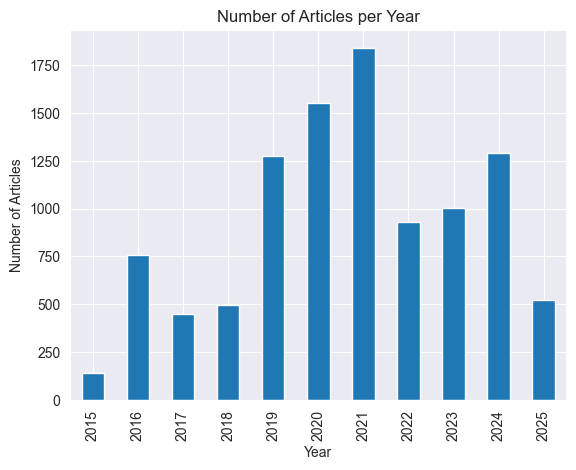

In [5]:
# === Plot 1: Number of articles per year ===
df['year'] = df['date'].dt.year
plt.figure()
df['year'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Articles per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.show()



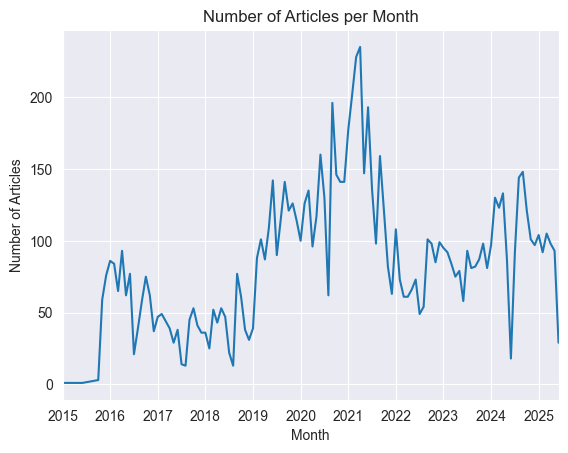

In [6]:
# === Plot 2: Number of articles per month ===
df['month'] = df['date'].dt.to_period('M')
plt.figure()
df['month'].value_counts().sort_index().plot(kind='line')
plt.title('Number of Articles per Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.show()


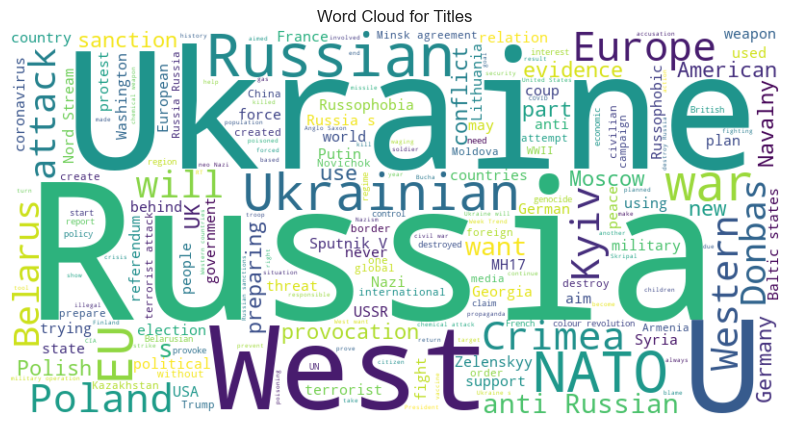

In [7]:
# === Plot 3: Word Cloud for Titles ===
if 'Title' in df.columns:
    title_text = ' '.join(df['Title'].dropna().astype(str).tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Titles')
    plt.show()



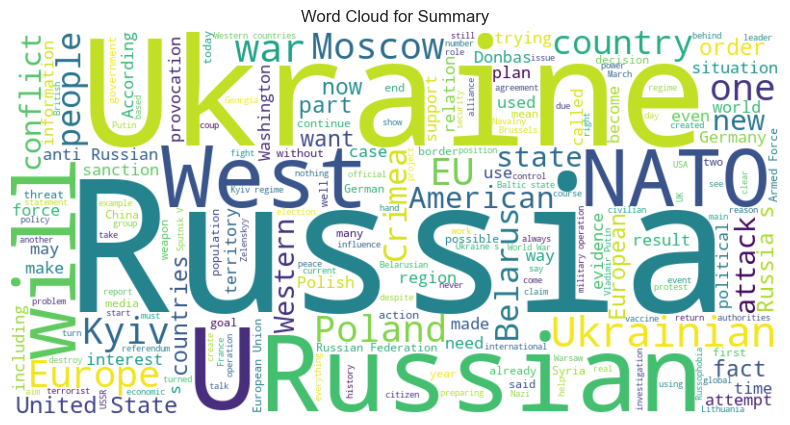

In [8]:
# === Plot 4: Word Cloud for Summaries ===
if 'Summary' in df.columns:
    desc_text = ' '.join(df['Summary'].dropna().astype(str).tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(desc_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Summary')
    plt.show()


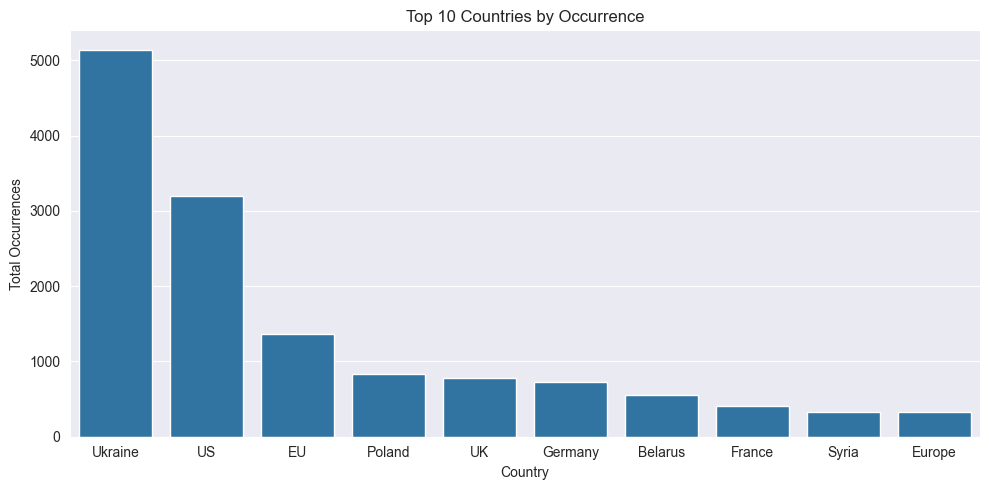

In [9]:
# === Plot 5: Top 10 countries by occurrence ===
if 'Countries' in df.columns:
    filtered_countries = df[df['Countries'] != "Countries"]
    country_lists = filtered_countries['Countries'].apply(ast.literal_eval)
    all_countries = [country for countries in country_lists for country in countries]
    country_counts = Counter(all_countries)
    country_counts_df = pd.DataFrame(country_counts.items(), columns=['Country', 'Count']).sort_values('Count', ascending=False)
    country_counts_df=country_counts_df.iloc[1:]

    plt.figure(figsize=(10, 5))
    sns.barplot(data=country_counts_df.head(10), x='Country', y='Count')
    plt.title('Top 10 Countries by Occurrence')
    plt.xlabel('Country')
    plt.ylabel('Total Occurrences')
    plt.tight_layout()
    plt.show()

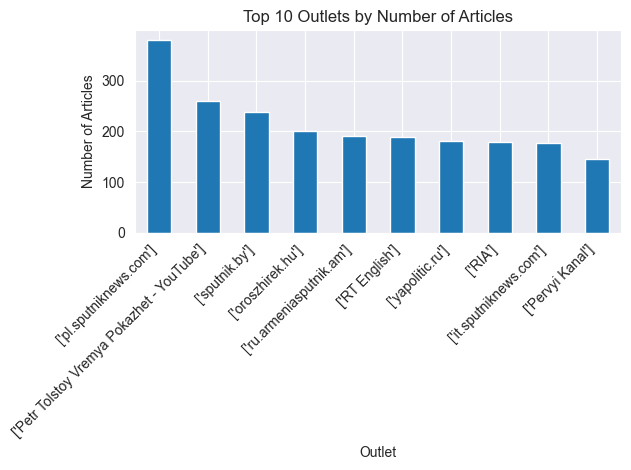

In [10]:
# === Plot 6: Top 10 outlets by number of articles ===
if 'Outlet' in df.columns:
    plt.figure()
    df['Outlet'].value_counts().head(10).plot(kind='bar')
    plt.title('Top 10 Outlets by Number of Articles')
    plt.xlabel('Outlet')
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



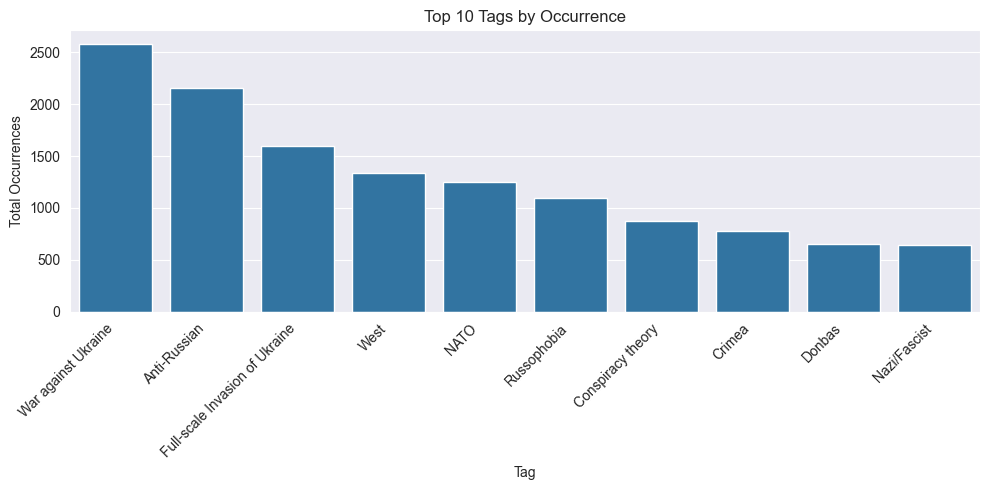

In [11]:
# === Plot 7: Top 10 tags by total occurrence ===
if 'Tags' in df.columns:
    filtered_tags = df[df['Tags'] != "Tags"]
    tag_lists = filtered_tags['Tags'].apply(ast.literal_eval)
    all_tags = [tag for tags in tag_lists for tag in tags]
    tag_counts = Counter(all_tags)
    tag_counts_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count']).sort_values('Count', ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(data=tag_counts_df.head(10), x='Tag', y='Count')
    plt.title('Top 10 Tags by Occurrence')
    plt.xlabel('Tag')
    plt.ylabel('Total Occurrences')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



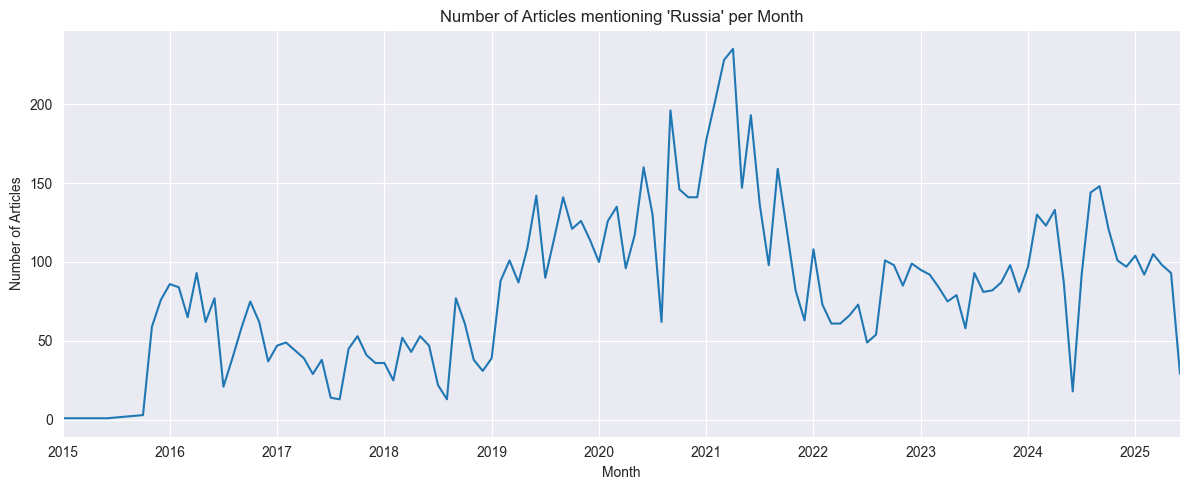

In [12]:
# === Plot 8: Evolution in time for a specific country (e.g., Russia) ===
country = 'Russia'
df['contains_russia'] = df['Countries'].apply(lambda x: country in ast.literal_eval(x) if pd.notnull(x) and x != "Countries" else False)
articles_by_month = df[df['contains_russia']].groupby(df['date'].dt.to_period('M')).size()
plt.figure(figsize=(12,5))
articles_by_month.plot()
plt.title(f"Number of Articles mentioning '{country}' per Month")
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

In [13]:
# === Plot 9: Average sentiment score per top 10 tags (if sentiment_score exists) ===
if 'sentiment_score' in df.columns and 'Tags' in df.columns:
    tag_sentiments = []
    for tag in tag_counts_df.head(10)['Tag']:
        mask = df['Tags'].apply(lambda x: tag in ast.literal_eval(x) if pd.notnull(x) and x != "Tags" else False)
        tag_sentiments.append(df[mask]['sentiment_score'].mean())
    plt.figure(figsize=(10,5))
    sns.barplot(x=tag_counts_df.head(10)['Tag'], y=tag_sentiments)
    plt.title('Average Sentiment Score per Top Tag')
    plt.xlabel('Tag')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [14]:
# === Topic Modeling: Main topics from Summary using LDA ===
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

if 'Summary' in df.columns:
    texts = df['Summary'].dropna().astype(str).tolist()
    vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
    X = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=5, random_state=0)
    lda.fit(X)
    for i, topic in enumerate(lda.components_):
        print(f"Topic #{i}: ", [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])



Topic #0:  ['sputnik', 'western', 'elections', 'information', 'eu', 'vaccine', 'european', 'media', 'russia', 'russian']
Topic #1:  ['poisoning', 'gas', 'world', 'western', 'chemical', 'syria', 'russian', 'west', 'navalny', 'russia']
Topic #2:  ['international', 'kyiv', 'ukrainian', '2014', 'eu', 'sanctions', 'russian', 'crimea', 'ukraine', 'russia']
Topic #3:  ['armed', 'regime', 'russia', 'attack', 'forces', 'military', 'kyiv', 'russian', 'ukraine', 'ukrainian']
Topic #4:  ['countries', 'states', 'military', 'poland', 'west', 'russian', 'war', 'nato', 'ukraine', 'russia']


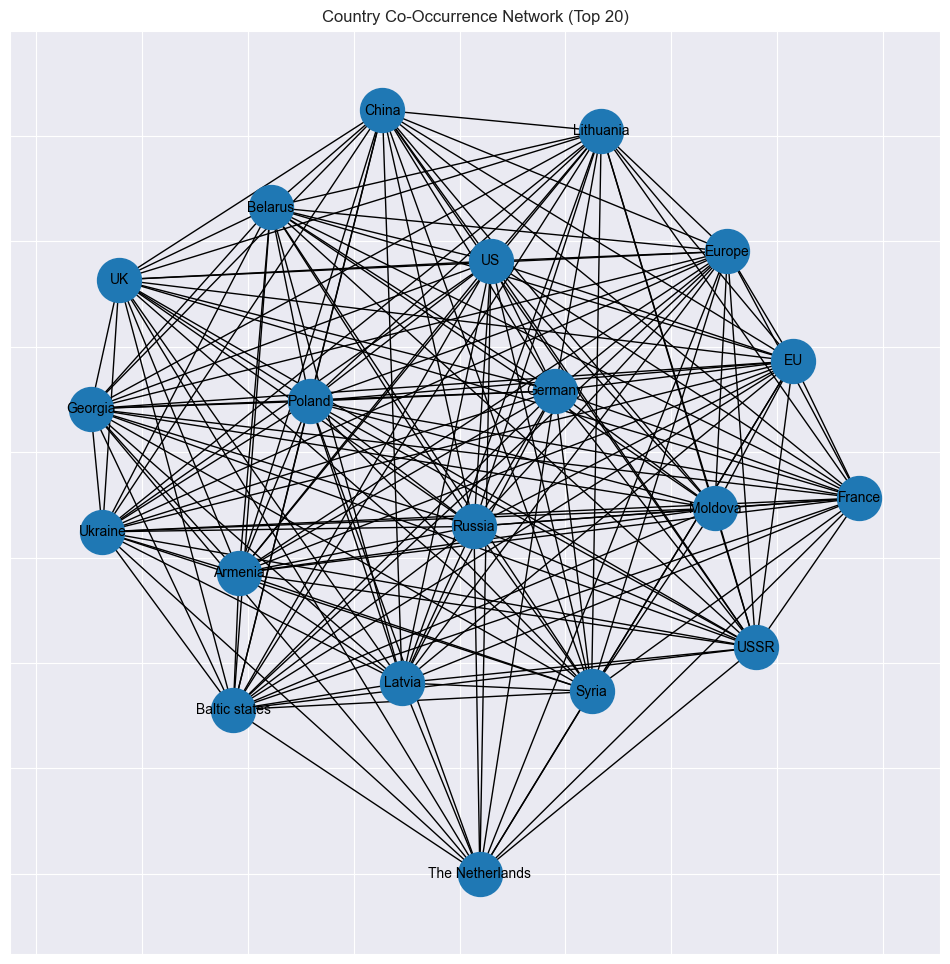

In [15]:
# === Plot 10: Country co-occurrence network graph (top 20) ===
import networkx as nx
from itertools import combinations

filtered_countries = df[df['Countries'] != "Countries"]
country_lists = filtered_countries['Countries'].apply(ast.literal_eval)
edges = []
for clist in country_lists:
    edges += list(combinations(sorted(set(clist)), 2))
G = nx.Graph()
G.add_edges_from(edges)
plt.figure(figsize=(12,12))
top_nodes = [node for node, _ in Counter(all_countries).most_common(20)]
nx.draw_networkx(G.subgraph(top_nodes), with_labels=True, node_size=1000, font_size=10)
plt.title("Country Co-Occurrence Network (Top 20)")
plt.show()

In [ ]:
!pip install torch transformers
!pip install tf-keras


In [7]:
from transformers import pipeline
import pandas as pd

# Initialize the emotion classification pipeline
emotion_pipe = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None,return_all_scores=False)

# Create a new column with the text length of each summary
df['text_length'] = df['Summary'].str.len()

# Mapping from emotion labels to emojis for better visualization
emotion_to_emoji = {
    "anger": "😠",
    "disgust": "🤢",
    "fear": "😨",
    "joy": "😄",
    "neutral": "😐",
    "sadness": "😢",
    "surprise": "😲",
    "others": "❓"
}

# Sort the DataFrame by text length and select the top 10 longest summaries
top10 = df.sort_values(by='text_length', ascending=False).head(10)

results = []
# For each of the top 10 longest summaries, predict the main emotion
for idx, row in top10.iterrows():
    text = row['Summary']
    # Limit the text length to 2000 characters to avoid model errors (adapt if needed)
    text = str(text)[:2000]
    emotion_result = emotion_pipe(text)
    # Select the emotion with the highest score
    main_emotion = max(emotion_result[0], key=lambda x: x['score'])
    label = main_emotion['label']
    # Map the emotion label to the corresponding emoji
    emoji = emotion_to_emoji.get(label.lower(), "❓")
    results.append({
        'index': idx,
        'emotion': label,
        'emoji': emoji,
        'title': row['Title']  # Use 'Title' or change if your column has a different name
    })

# Create a new DataFrame with the results
emotion_df = pd.DataFrame(results)

# Print only the relevant columns: index, emotion, emoji, score, and title
print(emotion_df[['index', 'emotion', 'emoji', 'title']])


Device set to use cpu


   index   emotion emoji                                              title
0   4471   neutral     😐     The US is hiding the truth from the MH17-trial
1   7308   neutral     😐  The West will support anti-Russian Ukraine unt...
2   7449     anger     😠  Three types of Russophobia are turning Belarus...
3   6594   neutral     😐  The US wishes to destabilise Belarus and provo...
4   7276     anger     😠  Amnesty International is an ideological tool o...
5   5051  surprise     😲  EUvsDisinfo denounces disinformation from Russ...
6    373      fear     😨  The Greens are behind the destruction of Germa...
7   6652   disgust     🤢  Western media try to minimise Soviet victory i...
8   8484   neutral     😐  The West has approved a new ‘Barbarossa’ plan ...
9   4575   disgust     🤢  Western foundations prepare the informative de...


In [24]:
!pip install sentence-transformers
!pip install hf_xet

In [26]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Load your data
df = pd.read_csv('euvsdisinfo_results_with_sentiment.csv')
examples = df['Summary'].dropna().tolist()  # Use the 'Summary' column (or another text column if needed)

# Load a pretrained model for generating embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for all disinformation cases in the dataset
embeddings = model.encode(examples, convert_to_tensor=True)

def check_if_fake(text, threshold=0.65):
    # Compute the embedding for the new text
    emb = model.encode([text], convert_to_tensor=True)
    # Calculate cosine similarity between the new text and all dataset examples
    cosine_scores = util.cos_sim(emb, embeddings)[0]
    # Get the highest similarity score
    best_score = cosine_scores.max().item()
    # Decide if the text is likely disinformation based on the threshold
    if best_score > threshold:
        print(f"⚠️ Warning! This text is similar to known Russian disinformation examples (similarity score: {best_score:.2f})")
    else:
        print(f"✅ This text does NOT resemble disinformation examples from the dataset (score: {best_score:.2f})")
    return best_score

# Test with a new example
text_nou = "Romania is in war with Ukrain."
check_if_fake(text_nou)

✅ Textul NU seamănă cu exemplele de dezinformare din dataset (scor: 0.62)


0.616150975227356